In [ ]:
import numpy as np
import openmc
import openmc.deplete
from pyne import serpent
import re
import matplotlib.pyplot as plt
from openmc.data import AVOGADRO, atomic_mass

In [ ]:
# Load OpenMC depletion results
dep_omc = openmc.deplete.Results(filename='openmc-results/depletion_results.h5')

# Load Serpent depletion results
dep_serpent = serpent.parse_dep('msbr_endfb71.serpent_dep.m', make_mats=False)
mat_name = []
mats = {}
for key in dep_serpent.keys():
    m = re.search('MAT_(.+?)_VOLUME', key)
    if m:
        mat_name.append(m.group(1))
z_names = dep_serpent['NAMES'][0].split()[:-2]  # zzaaam codes of isotopes
nucvec = dict(zip(z_names, dep_serpent['MAT_' + mat_name[0] + '_MDENS'][:]))

res_serpent = serpent.parse_res('msbr_endfb71.serpent_res.m')

In [ ]:
X = 'Ag110_m1'
t = dep_omc.get_atoms('1', X, 'atom/cm3', time_units='d')[0]
mdens_omc = dep_omc.get_atoms('1', X, 'atom/cm3', time_units='d')[1] * atomic_mass(X) / AVOGADRO
X = 'Ag110m'
mdens_serp = nucvec[X]

plt.plot(t, mdens_omc, label=f'{X} OpenMC')
plt.plot(t, mdens_serp, label=f'{X} Serpent')
plt.ylabel('Concentration [g/cm3]')
plt.xlabel('Time [d]')
plt.legend()

# Relative error
plt.figure()
plt.plot(t, (mdens_serp - mdens_omc)/mdens_serp)
plt.ylabel('Concentration [g/cm3]')
plt.xlabel('Time [d]')
plt.title(f'Error in OpenMC {X} concentration relative to Serpent')


In [ ]:
dep_omc = openmc.deplete.Results.from_hdf5('openmc-results/depletion_results.h5')


t, keff_omc = dep_omc.get_keff(time_units='d')
kcol_omc = []
kcol_omc_err = []
kabs_omc = []
kabs_omc_err = []
for i in range(0, len(t)):
    sp = openmc.StatePoint(f'openmc-results/openmc_simulation_n{i}.h5')
    kcol_omc.append(sp.global_tallies[0][3])
    kcol_omc_err.append(sp.global_tallies[0][4])
    kabs_omc.append(sp.global_tallies[1][3])
    kabs_omc_err.append(sp.global_tallies[1][4])
    sp.close()
    
kcom_omc_err = keff_omc[:,1]
kcom_omc = keff_omc[:,0]

<Figure size 432x288 with 0 Axes>

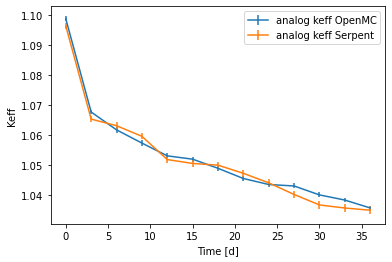

<Figure size 432x288 with 0 Axes>

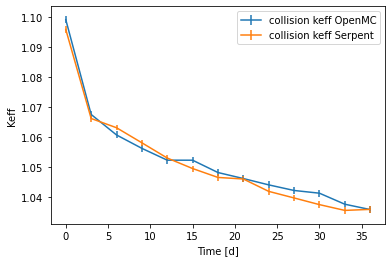

<Figure size 432x288 with 0 Axes>

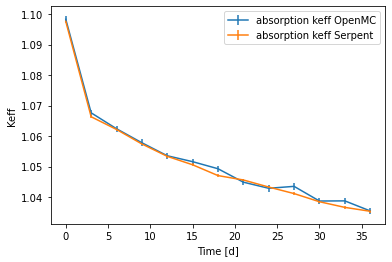

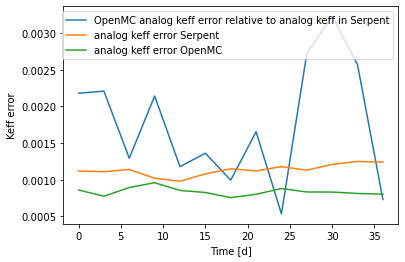

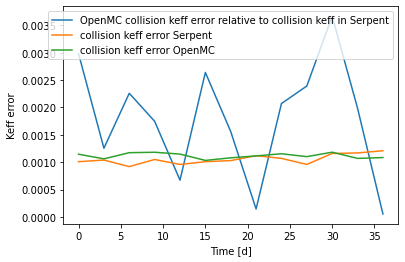

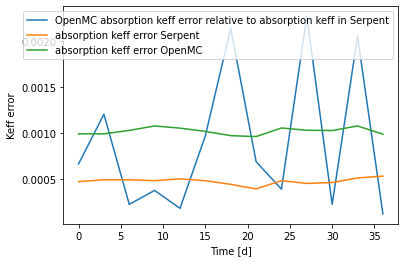

In [26]:
#plt.errorbar(t, keff_omc, yerr=keff_omc_err, label='keff OpenMC')
smap = {'analog':[(kcom_omc, kcom_omc_err), 'ANA'], 
        'collision':[(kcol_omc, kcol_omc_err), 'COL'], 
        'absorption':[(kabs_omc, kabs_omc_err), 'ABS']}
for s, v in smap.items():
    plt.figure()
    keff_omc = v[0][0]
    keff_omc_err = v[0][1]
    keff_serp = res_serpent[f'{v[-1]}_KEFF'][:,0]
    keff_serp_err = res_serpent[f'{v[-1]}_KEFF'][:,1]
    plt.figure()
    plt.errorbar(t, keff_omc, yerr=keff_omc_err, label=f'{s} keff OpenMC')
    plt.errorbar(t, keff_serp, yerr=keff_serp_err, label=f'{s} keff Serpent')
    
    plt.ylabel('Keff')
    plt.xlabel('Time [d]')
    plt.legend()

for s, v in smap.items():
    plt.figure()
    keff_omc = v[0][0]
    keff_omc_err = v[0][1]
    keff_serp = res_serpent[f'{v[-1]}_KEFF'][:,0]
    keff_serp_err = res_serpent[f'{v[-1]}_KEFF'][:,1]
    plt.plot(t, np.abs((keff_serp-keff_omc)/keff_serp), label=f'OpenMC {s} keff error relative to {s} keff in Serpent')
    #plt.plot(t, np.abs((keff_omc-keff_serp)/keff_omc), label=f'Serpent {s} keff error relative to keff in OpenMC')
    plt.plot(t, keff_serp_err, label=f'{s} keff error Serpent')
    plt.plot(t, keff_omc_err, label=f'{s} keff error OpenMC')
    plt.ylabel('Keff error')
    plt.xlabel('Time [d]')
    plt.legend()